In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, merge, Input, concatenate, Reshape, add
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model 
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from kerastoolbox.visu import plot_weights
from statistics import mode
import time
%matplotlib notebook

Using TensorFlow backend.


In [25]:
# load model and do analysis
global model
model = load_model(filepath="model/pattern_analyzer_tablework_idle_walk_exercise_final acc: 0.993319710783.hdf5")
model._make_predict_function()

<IPython.core.display.Javascript object>


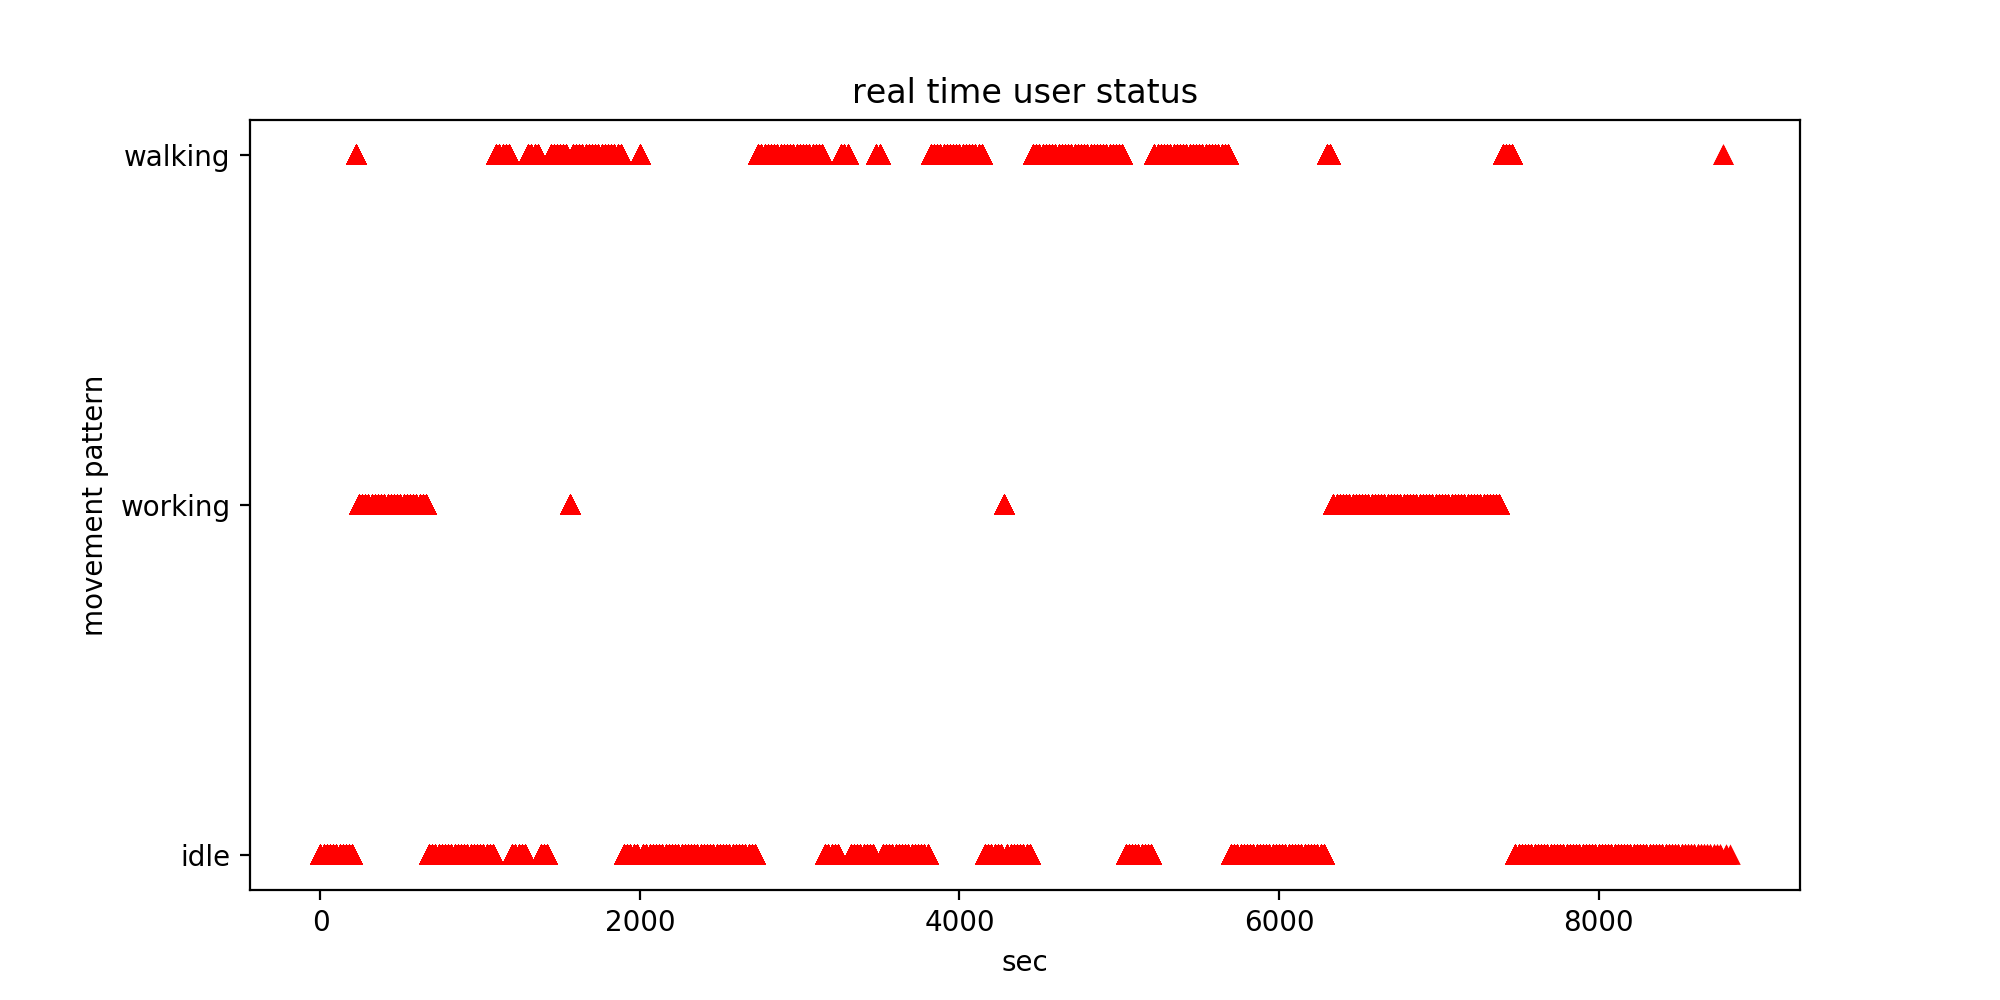

In [82]:
# take graphs
global pattern, temp_pattern, sum_len
global x, x_copy, fig, plot
global csvfile2, check_email_condition
check_email_condition = False
csvfile2= open("reading.csv","w")
title2=["time", "ECO2","TVOC"]
csv.writer(csvfile2).writerow(title2)
sum_len = 20
fig = plt.figure(figsize=[10, 5])
plt.ylabel('movement pattern')
plt.xlabel('sec')
plt.yticks([0, 1, 2], ['idle', 'working', 'walking'])
# plt.yticks([0, 1, 2, 3], ['idle', 'working', 'sports', 'walking'])
pattern = []
temp_pattern = []
x = 0

In [83]:
def filter_pattern(patterns):
    try:
        temp = mode(patterns)
    except:
        temp = np.median(patterns)
    return temp

def draw_state():
    global plt, fig, pattern, sum_len, x_copy
    plt.title("real time user status")
    plt.plot([sum_len * i for i in range(int(x_copy / sum_len))], pattern, '^r')
    fig.canvas.draw()
    time.sleep(0.05)

def which_pattern(sequence):
    global model, fig, x, pattern, x_copy, temp_pattern
    pred = model.predict(x=sequence)
    model.reset_states()
    pred = pred[0]
    index = pred.argmax(axis=0)
    value = pred.max()
    x += 1
    temp_pattern.append(index)
    if x%sum_len == 0:
        pattern.append(filter_pattern(temp_pattern))
        x_copy = x
        temp_pattern = []
        t = threading.Thread(target=draw_state)
        t.setDaemon(True)
        t.start()
    if pattern == 2 and not check_email_condition:
        air_tvoc = 0
        air_tvoc_max = 10000
        if (air_tvoc > air_tvoc_max):
            postEmail("bad_air_tvoc")
            check_email_condition = True
    # print("in stat ", index, " with confidence ", value)
    return index

In [84]:
import paho.mqtt.client as mqttClient
import time
import csv
import numpy as np
import random
import threading

global csvfile
global gravity
global seconds
global standardData
global lastSwitchTime
global Switch, Pending, init
global sequence
global counter
global secondCounter
global numInSecond
global data
global threadRunning
global stopThread


from urllib.parse import urlencode
from urllib.request import Request, urlopen
def postEmail(content):
    #low_light
    #high_light
    #bad_air_tvoc
    #bad_air_eco2
    url = 'http://maker.ifttt.com/trigger/{}/with/key/hA6-jzN0qr7kv2SnNIvNOI4aU0exwuVj-9sPuzGiwAl'.format(content)
    post_fields = {'foo':'bar'}
    request = Request(url, urlencode(post_fields).encode())
    json = urlopen(request).read().decode()
    print(json)

def target():
    global client
    global threadRunning
    threadRunning=True
    print('the curent threading  %s is running' % threading.current_thread().name)
    while stopThread!=True:
        time.sleep(1)
        localtime = time.asctime(time.localtime(time.time()))
        client.publish("python/test","T {}".format(str(localtime)))
    client.publish("python/test","D ")
    print('the curent threading  %s is ended' % threading.current_thread().name)
    threadRunning=False

def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Connected to broker")
        global Connected  # Use global variable
        Connected = True  # Signal connection
    else:
        print("Connection failed")


def checkSatisfied(gravity):
    # Check whether the gesture is within the standard.
    global standardData
    tol = 0.5
    limit = 0.3
    satisfied = True
    if abs(gravity[0] - standardData[0]) > limit:
        satisfied = False
        tol = tol - abs(gravity[0] - standardData[0])
    if abs(gravity[1] - standardData[1]) > limit:
        satisfied = False
        tol = tol - abs(gravity[1] - standardData[1])
    if abs(gravity[2] - standardData[2]) > limit:
        satisfied = False
        tol = tol - abs(gravity[2] - standardData[2])
    if tol < 0:
        satisfied = False
    if (satisfied):
        return True
    else:
        return False

def processApplication(context):
    global sequence
    global counter
    # print(context)
    if (counter <= 99):
        sequence[counter, 0] = float(context[2])
        sequence[counter, 1] = float(context[3])
        sequence[counter, 2] = float(context[4])
        counter += 1
        # print(counter)
    else:
        newSequence = np.zeros((100, 3))
        # print (sequence)
        newSequence[0:-1, :] = sequence[1:, :]
        newSequence[-1, 0] = float(context[2])
        newSequence[-1, 1] = float(context[3])
        newSequence[-1, 2] = float(context[4])
        # output newSequence here
        sequence = newSequence
        # print(sequence)
        which_pattern(np.array([sequence]))


def padding(data):
    #data list
    global numInSecond
    newData=[]
    x=len(data)
    print(x)
    if x > 6:
        if x < numInSecond:
            newIndex = [random.choice(range(x)) for _ in range(numInSecond)]
            newData = [data[item] for item in sorted(newIndex)]
        elif x > numInSecond:
            newIndex = random.sample(range(x), numInSecond)
            newData = [data[item] for item in sorted(newIndex)]
        else:
            newData = data
        # print(newData)
        for i in newData:
            processApplication(i)
        #saveData(newData)

def saveData(data):
    for i in data:
        global csvfile
        csv.writer(csvfile).writerow(i)
        #processApplication(i)


def on_message(client, userdata, message):
    global numInSecond
    global seconds
    global data
    global secondCounter
    if (seconds == -1):
        seconds = time.time()
    if str(message.payload)[2]=="T" :
        #print("Ignore message!")
        return 0
    if str(message.payload)[2]=="D" :
        #print("Ignore message!")
        return 0
    if str(message.payload)[2]=="C":
        print(str(message.payload)[2:-1])
        global csvfile2
        text=str(message.payload)[2:-1].split()
        currentTime = time.time() - seconds
        newrow = [currentTime]
        newrow.append(text[2])
        newrow.append(text[4])
        csv.writer(csvfile2).writerow(newrow)
        return 0
    #print ("Message received: " + str(message.payload))
    context = str(message.payload)[2:-1].split()

    currentTime=time.time() - seconds
    newrow = [currentTime]
    newrow.extend(context)

    if (currentTime<(secondCounter+0.99)):
        data.append(newrow)
    elif (currentTime>=(secondCounter+0.99) ):
        secondCounter+=1
        padding(data)
        data=[]


    global gravity

    alpha=0.2

    gravity[0] = alpha * gravity[0] + (1 - alpha) * float(context[1])
    gravity[1] = alpha * gravity[1] + (1 - alpha) * float(context[2])
    gravity[2] = alpha * gravity[2] + (1 - alpha) * float(context[3])


    #check gesture
    global init
    global stopThread
    pendingTime = 0.2
    checkResult = checkSatisfied(gravity)
    currentTime = time.time()

    global Pending, lastSwitchTime, Switch

    if not (init):
        Switch = checkResult
        print("Command {}".format(Switch))
        Pending = False
        init = True
    else:
        # print (checkResult)
        # print(Switch,  checkResult)
        if (Switch != checkResult):
            if not (Pending):
                Pending = True
                lastSwitchTime = currentTime
            else:
                if (currentTime - lastSwitchTime) >= pendingTime:
                    Switch = checkResult
                    Pending = False
                    print("Command {}".format(Switch))
                    if (Switch):
                        stopThread=False
                        t = threading.Thread(target=target)
                        t.setDaemon(True)
                        t.start()
                    else:
                        stopThread=True

        else:
            if Pending:
                Pending = False



def on_subscribe(mosq, obj, mid, granted_qos):
    print("Subscribed OK")
    print(mosq, obj, mid, granted_qos)


def on_unsubscribe(mosq, obj, mid, granted_qos):
    print("Unsubscribed OK")

In [ ]:
stopThread=False
threadRunning=False
numInSecond=20
data=[]
secondCounter=0
counter=0
sequence=np.zeros((100, 3))
init=False
Pending=False
Switch=True
standardData=np.array([-0.352390461,-0.019114219,0.93773655])
seconds=-1
gravity=np.array([0.0,0.0,0.981])
Connected = False  # global variable for the state of the connection
broker_address = "m23.cloudmqtt.com"  # Broker address
port = 13299  # Broker port
user = "frylvkng"  # Connection username
password = "WWqMi9zd5xEa"  # Connection password
global client
client = mqttClient.Client("Python0")  # create new instance
client.username_pw_set(user, password=password)  # set username and password
client.on_connect = on_connect  # attach function to callback
client.on_message = on_message  # attach function to callback
client.on_subscribe = on_subscribe
client.on_unsubscribe=on_unsubscribe

client.connect(broker_address, port=port)  # connect to broker

client.loop_start()  # start the loop

while Connected != True:  # Wait for connection
    time.sleep(0.1)

client.subscribe("python/test")
csvfile= open("test.csv","w")
title=["time","index","x","y","z"]
csv.writer(csvfile).writerow(title)
#client.loop_forever()
try:
    while True:
        time.sleep(0.01)

except KeyboardInterrupt:
    print("exiting",client.disconnect(),client.loop_stop())
    pattern_data = []
    pattern_data.append(len([0 for item in pattern if item == 0]))
    pattern_data.append(len([0 for item in pattern if item == 1]))
    pattern_data.append(len([0 for item in pattern if item == 2]))

    labels = ['Idle', 'Working', 'Walking']

    width=0.8
    fig1 = plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    ax.set_ylabel("sec")
    ax.bar(range(len(labels)), pattern_data, width=width, color=['b', 'r', 'g'])
    ax.set_xticks(range(3))
    ax.set_xticklabels(labels)
    plt.show()

Connected to broker
Subscribed OK
<paho.mqtt.client.Client object at 0x12bdb55f8> None 1 (0,)
Command True
Command False
18
14
16
10
19
17
23
28
Command Truethe curent threading  Thread-1792 is running

17
20
0
0
Command False
the curent threading  Thread-1792 is ended
0
0
0
0
36
C eco2: 65021 tvoc: 65021
36
35
34
10
18
16
28
40
39
C eco2: 400 tvoc: 0
30
27
15
17
28
30
17
12
41
C eco2: 400 tvoc: 0
35
32
31
27
24
19
18
17
7
0
23
C eco2: 400 tvoc: 0
30
34
31
35
39
39
37
C eco2: 400 tvoc: 0
38
40
34
19
23
38
26
39
C eco2: 400 tvoc: 0
30
27
24
17
19
33
22
41
38
C eco2: 400 tvoc: 0
39
35
40
29
25
39
38
C eco2: 410 tvoc: 1
33
39
22
23
39
38
39
C eco2: 417 tvoc: 2
34
24
23
18
13
10
5
14
30
41
C eco2: 408 tvoc: 1
39
39
39
41
40
39
40
C eco2: 400 tvoc: 0
27
51
23
39
37
31
11
15
C eco2: 445 tvoc: 6
24
33
41
33
39
41
39
C eco2: 400 tvoc: 0
35
35
25
23
36
36
18
22
C eco2: 405 tvoc: 0
27
38
36
22
20
14
31
38
C eco2: 409 tvoc: 1
37
23
0
0
0
0
9
37
38
37
38
39
C eco2: 424 tvoc: 3
21
30
31
34
17
6
1
1

<IPython.core.display.Javascript object>


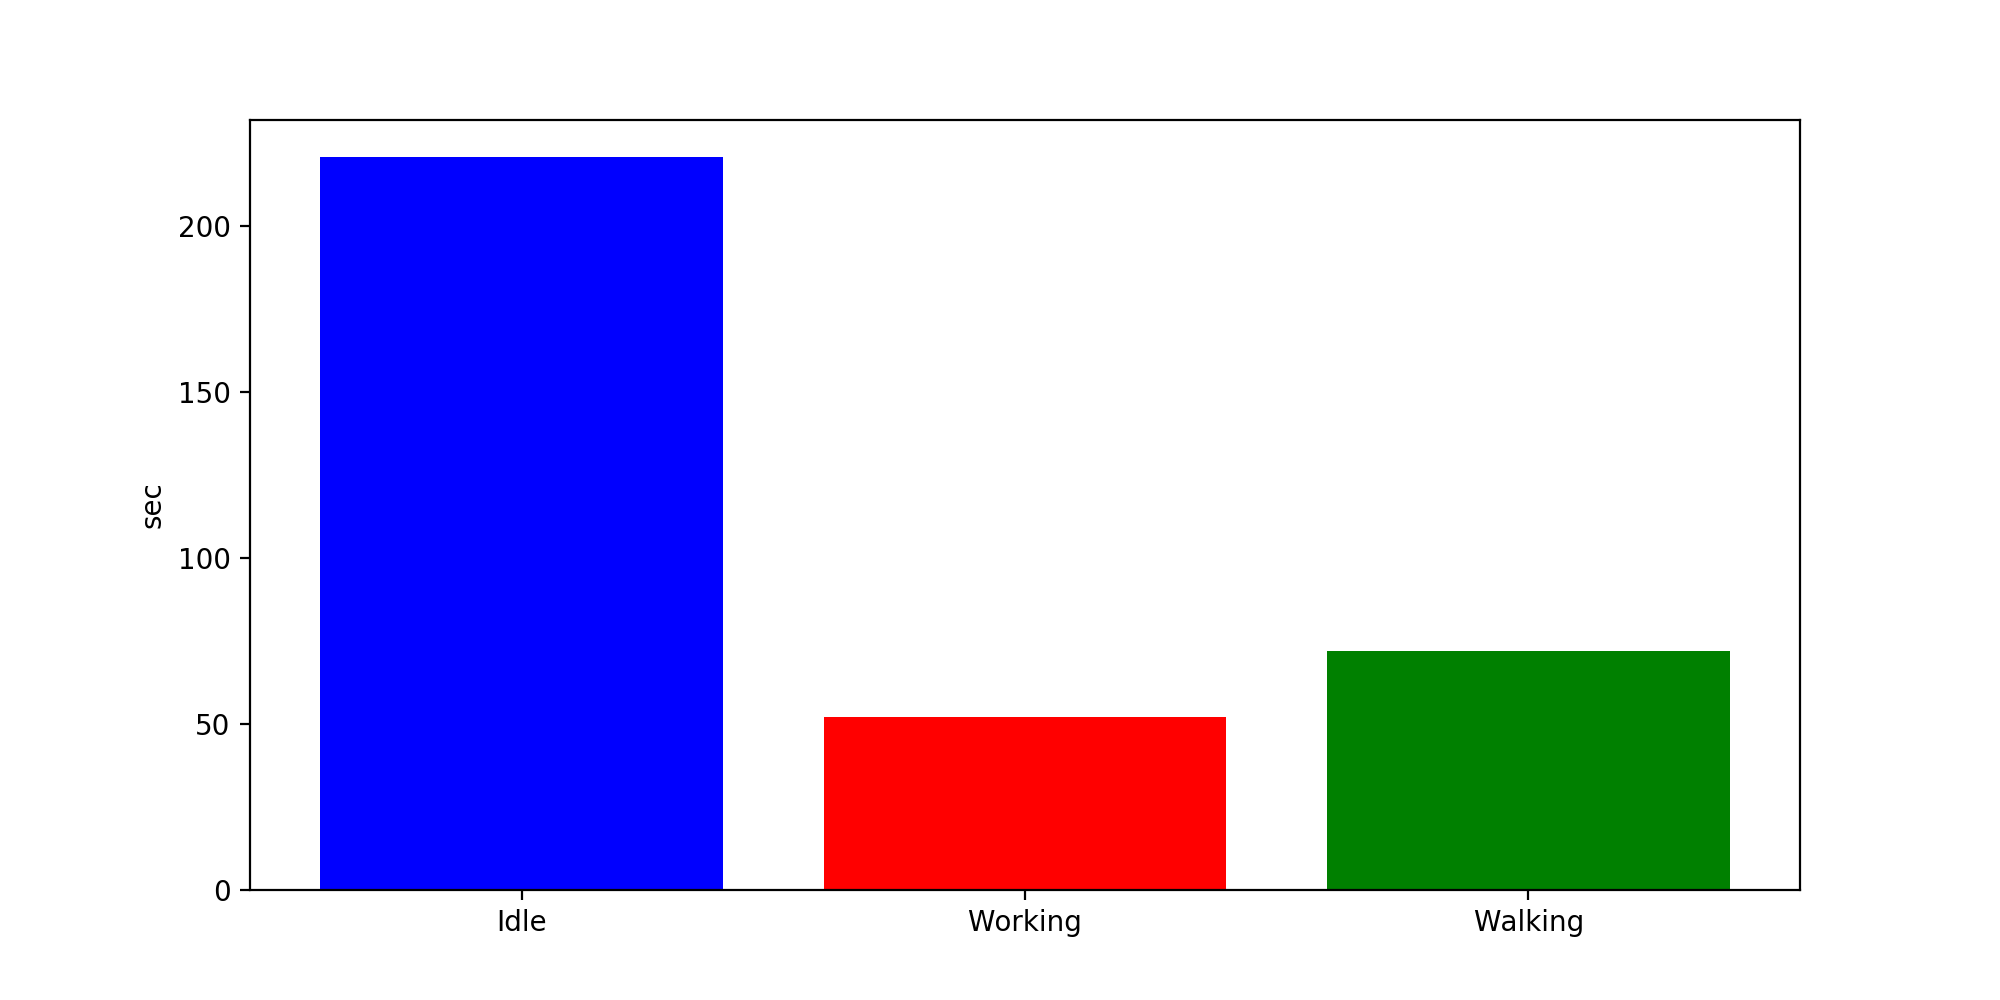

In [80]:
pattern_data = []
pattern_data.append(len([0 for item in pattern if item == 0]))
pattern_data.append(len([0 for item in pattern if item == 1]))
pattern_data.append(len([0 for item in pattern if item == 2]))

labels = ['Idle', 'Working', 'Walking']

width=0.8
fig1 = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.set_ylabel("sec")
ax.bar(range(len(labels)), pattern_data, width=width, color=['b', 'r', 'g'])
ax.set_xticks(range(3))
ax.set_xticklabels(labels)
plt.show()